In [1]:
# import os
# import random
# import pandas as pd
# import numpy as np
# import torch as tc
# from sklearn.metrics import f1_score
# from models.rnn.simple_rnn_keras import SimpleRNNKeras
# from models.rnn.simple_rnn_manual import SimpleRNNManual
# from helper.text_vectorization import TextPreprocessor
# import tensorflow as tf

# SEED = 42
# os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)  
# tc.manual_seed(SEED)
# tc.backends.cudnn.deterministic = True
# tc.backends.cudnn.benchmark = False
# tc.use_deterministic_algorithms(True)


# train_df = pd.read_csv("../data/nusaX-sentiment/train.csv")
# valid_df = pd.read_csv("../data/nusaX-sentiment/valid.csv")
# test_df  = pd.read_csv("../data/nusaX-sentiment/test.csv")

# label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# y_train = train_df["label"].map(label_map).values.astype(np.int32)
# y_valid = valid_df["label"].map(label_map).values.astype(np.int32)
# y_test  = test_df["label"].map(label_map).values.astype(np.int32)


# prep = TextPreprocessor(max_vocab=10000, max_len=100)
# prep.adapt(train_df["text"])

# X_train = prep.transform(train_df["text"])
# X_valid = prep.transform(valid_df["text"])
# X_test  = prep.transform(test_df["text"])


# model_keras = SimpleRNNKeras(
#     max_vocab=10000,
#     max_len=100,
#     rnn_units=[64],
#     dense_units=[32, 3],
#     dense_activations=['relu', 'softmax'],
#     bidirectional=True
# )

# model_keras.set_vectorized_data(
#     X_train=X_train,
#     y_train=y_train,
#     X_valid=X_valid,
#     y_valid=y_valid,
#     X_test=X_test,
#     y_test=y_test
# )

# model_keras.build_model()
# model_keras.train(epochs=5)
# model_keras.plot_loss()
# model_keras.save_full_npz("model_simple_rnn.npy")


# model_manual = SimpleRNNManual()
# model_manual.load_full_npz("model_simple_rnn.npy")

# X_test_tensor = tc.tensor(X_test.numpy(), dtype=tc.long)
# y_test_tensor = tc.tensor(y_test, dtype=tc.long)


# y_pred_keras = model_keras.model.predict(X_test)
# y_pred_keras = y_pred_keras.argmax(axis=1)

# y_pred_manual = model_manual.predict(X_test_tensor).cpu().numpy()

# f1_keras = f1_score(y_test, y_pred_keras, average='macro')
# f1_manual = f1_score(y_test, y_pred_manual, average='macro')

# print(f"Keras  F1-score:   {f1_keras:.8f}")
# print(f"Manual F1-score:  {f1_manual:.8f}")


In [2]:
import os
import random
import pandas as pd
import numpy as np
import torch as tc
from sklearn.metrics import f1_score
from models.rnn.simple_rnn_keras import SimpleRNNKeras
from models.rnn.simple_rnn_manual import SimpleRNNManual
from helper.text_vectorization import TextPreprocessor
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from models.rnn.simple_rnn_keras import SimpleRNNKeras

In [3]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  
tc.manual_seed(SEED)
tc.backends.cudnn.deterministic = True
tc.backends.cudnn.benchmark = False
tc.use_deterministic_algorithms(True)
tf.config.experimental.enable_op_determinism()



train_df = pd.read_csv("../data/nusaX-sentiment/train.csv")
valid_df = pd.read_csv("../data/nusaX-sentiment/valid.csv")
test_df  = pd.read_csv("../data/nusaX-sentiment/test.csv")

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

y_train = train_df["label"].map(label_map).values.astype(np.int32)
y_valid = valid_df["label"].map(label_map).values.astype(np.int32)
y_test  = test_df["label"].map(label_map).values.astype(np.int32)


prep = TextPreprocessor(max_vocab=10000, max_len=100)
prep.adapt(train_df["text"])

X_train = prep.transform(train_df["text"])
X_valid = prep.transform(valid_df["text"])
X_test  = prep.transform(test_df["text"])

# Uji coba banyak layer RNN

In [4]:
rnn_variants = [
    [64],           # 1 layer
    [64, 64],       # 2 layers
    [64, 64, 64]   # 3 layers
]

results = []

In [5]:
for config in rnn_variants:
    print(f"\nTraining RNN dengan konfigurasi layer: {config}")
    
    rnn_activations = []
    
    for i in range(len(config)):
        rnn_activations.append('tanh')

    model = SimpleRNNKeras(
        max_vocab=10000,
        max_len=100,
        rnn_units=config,
        rnn_activations=rnn_activations,
        dense_units=[32, 3],
        dense_activations=['relu', 'softmax'],
        bidirectional=True,
        dropout=0.3,
        learning_rate=1e-3
    )

    model.set_vectorized_data(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid,
        X_test=X_test,
        y_test=y_test
    )

    model.build_model()
    history = model.model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=20,
        batch_size=64,
        verbose=0,
        shuffle=False
    )

    y_pred_keras = np.argmax(model.model.predict(X_test), axis=1)
    f1_keras = f1_score(y_test, y_pred_keras, average='macro')

    path = f"model_rnn_{len(config)}layer.npy"
    model.save_full_npz(path)

    results.append({
        'config': config,
        'f1_keras': f1_keras,
        'y_pred_keras': y_pred_keras,
        'npz_path': path,
        'history': history.history,
        'model': model
    })

    print(f"F1-score (Keras)  → {f1_keras:.8f}")



Training RNN dengan konfigurasi layer: [64]
Adding RNN layer 1 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Saved full model to model_rnn_1layer.npy
F1-score (Keras)  → 0.60114472

Training RNN dengan konfigurasi layer: [64, 64]
Adding RNN layer 1 with 64 units and activation tanh
Adding RNN layer 2 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Saved full model to model_rnn_2layer.npy
F1-score (Keras)  → 0.51171998

Training RNN dengan konfigurasi layer: [64, 64, 64]
Adding RNN layer 1 with 64 units and activation tanh
Adding RNN layer 2 with 64 units and activation tanh
Adding RNN layer 3 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Saved full model to model_rnn_3layer.npy
F1-score (Keras)  → 0.50799310


In [6]:
X_test_tensor = tc.tensor(X_test.numpy(), dtype=tc.long)
y_test_tensor = tc.tensor(y_test, dtype=tc.long)

for result in results:
    manual_model = SimpleRNNManual()
    manual_model.load_full_npz(result['npz_path'])

    y_pred_manual = manual_model.predict(X_test_tensor).cpu().numpy()
    f1_manual = f1_score(y_test, y_pred_manual, average='macro')

    result['y_pred_manual'] = y_pred_manual
    result['f1_manual'] = f1_manual

    print(f"F1-score (Manual) → {f1_manual:.8f}")

F1-score (Manual) → 0.60114472
F1-score (Manual) → 0.51171998
F1-score (Manual) → 0.50799310


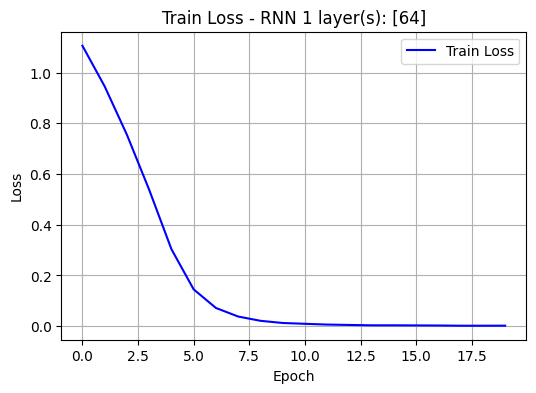

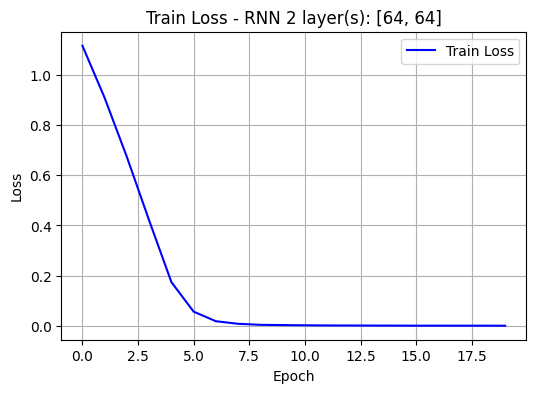

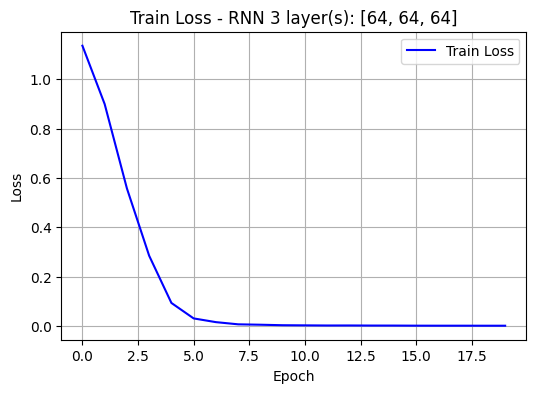

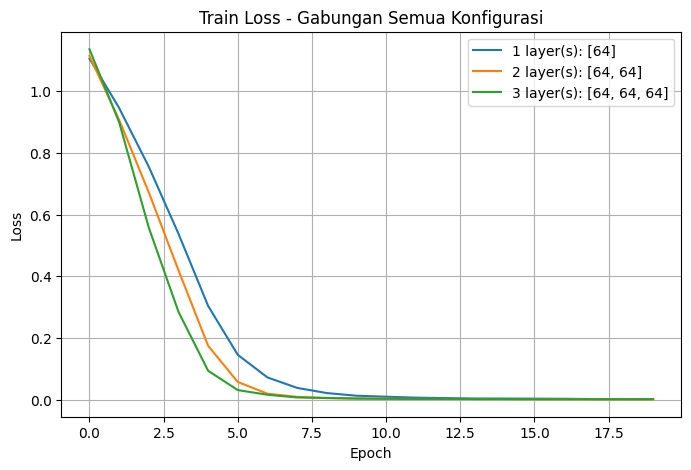

In [7]:
for result in results:
    config = result['config']
    loss = result['history']['loss']

    plt.figure(figsize=(6, 4))
    plt.plot(loss, color='blue', label='Train Loss')
    plt.title(f"Train Loss - RNN {len(config)} layer(s): {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    loss = result['history']['loss']
    label = f"{len(config)} layer(s): {config}"
    plt.plot(loss, label=label)

plt.title("Train Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()




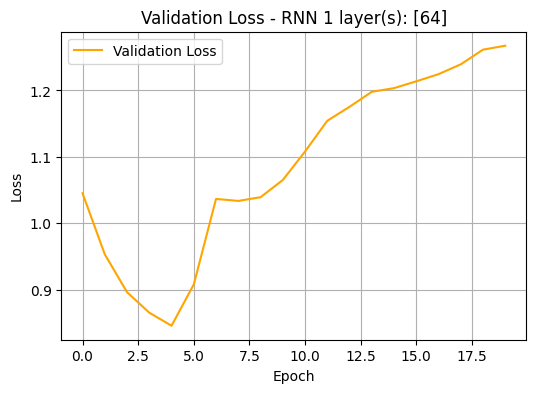

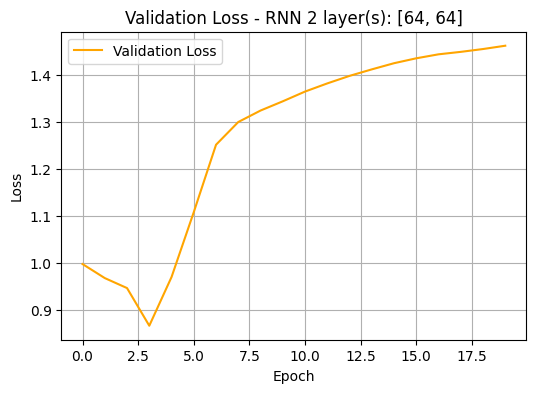

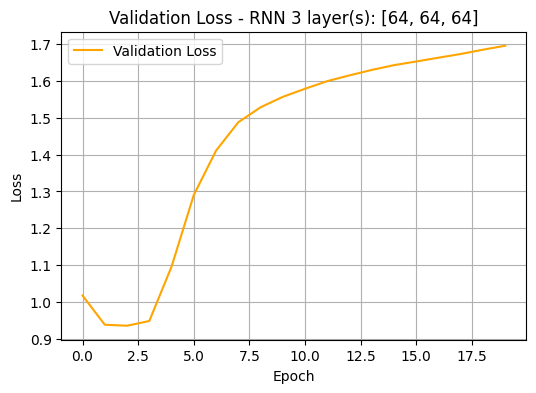

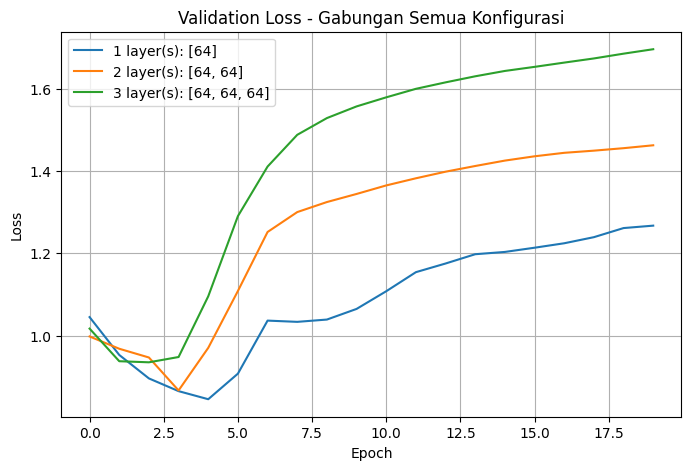

In [8]:
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']

    plt.figure(figsize=(6, 4))
    plt.plot(val_loss, color='orange', label='Validation Loss')
    plt.title(f"Validation Loss - RNN {len(config)} layer(s): {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']
    label = f"{len(config)} layer(s): {config}"
    plt.plot(val_loss, label=label)

plt.title("Validation Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


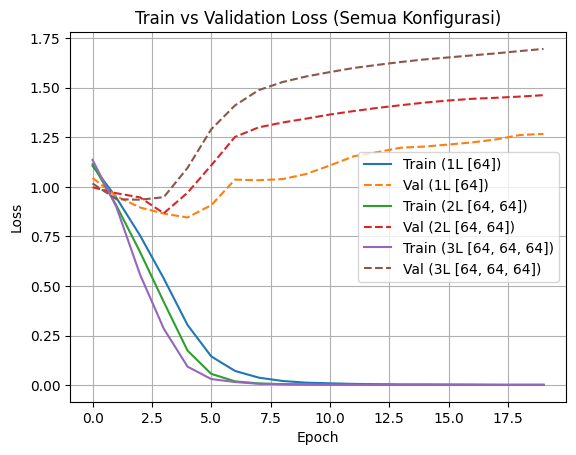

In [9]:
for result in results:
    config = result['config']
    history = result['history']
    label = f"{len(config)}L {config}"

    plt.plot(history['loss'], label=f"Train ({label})", linestyle='-')
    plt.plot(history['val_loss'], label=f"Val ({label})", linestyle='--')

plt.title("Train vs Validation Loss (Semua Konfigurasi)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
print("REKAP F1-SCORE PER KONFIGURASI:")
for result in results:
    print(f"RNN {result['config']} → F1 Keras: {result['f1_keras']:.4f} | F1 Manual: {result['f1_manual']:.4f}")



REKAP F1-SCORE PER KONFIGURASI:
RNN [64] → F1 Keras: 0.6011 | F1 Manual: 0.6011
RNN [64, 64] → F1 Keras: 0.5117 | F1 Manual: 0.5117
RNN [64, 64, 64] → F1 Keras: 0.5080 | F1 Manual: 0.5080


# Uji coba banyak neuron dalam 1 layer RNN

In [11]:
rnn_variants = [
    [64],          
    [128],      
    [256]  
]

results = []

In [12]:
for config in rnn_variants:
    print(f"\nTraining RNN dengan konfigurasi layer: {config}")

    model = SimpleRNNKeras(
        max_vocab=10000,
        max_len=100,
        rnn_units=config,
        rnn_activations=['tanh'],
        dense_units=[32, 3],
        dense_activations=['relu', 'softmax'],
        bidirectional=True,
        dropout=0.3,
        learning_rate=1e-3
    )

    model.set_vectorized_data(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid,
        X_test=X_test,
        y_test=y_test
    )

    model.build_model()
    history = model.model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=20,
        batch_size=64,
        verbose=0,
        shuffle=False
    )

    y_pred_keras = np.argmax(model.model.predict(X_test), axis=1)
    f1_keras = f1_score(y_test, y_pred_keras, average='macro')

    path = f"model_rnn_layer{config}.npy"
    model.save_full_npz(path)

    results.append({
        'config': config,
        'f1_keras': f1_keras,
        'y_pred_keras': y_pred_keras,
        'npz_path': path,
        'history': history.history,
        'model': model
    })

    print(f"F1-score (Keras)  → {f1_keras:.8f}")



Training RNN dengan konfigurasi layer: [64]
Adding RNN layer 1 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Saved full model to model_rnn_layer[64].npy
F1-score (Keras)  → 0.57262973

Training RNN dengan konfigurasi layer: [128]
Adding RNN layer 1 with 128 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Saved full model to model_rnn_layer[128].npy
F1-score (Keras)  → 0.57262640

Training RNN dengan konfigurasi layer: [256]
Adding RNN layer 1 with 256 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved full model to model_rnn_layer[256].npy
F1-score (Keras)  → 0.18269812


In [13]:
X_test_tensor = tc.tensor(X_test.numpy(), dtype=tc.long)
y_test_tensor = tc.tensor(y_test, dtype=tc.long)

for result in results:
    manual_model = SimpleRNNManual()
    manual_model.load_full_npz(result['npz_path'])

    y_pred_manual = manual_model.predict(X_test_tensor).cpu().numpy()
    f1_manual = f1_score(y_test, y_pred_manual, average='macro')

    result['y_pred_manual'] = y_pred_manual
    result['f1_manual'] = f1_manual

    print(f"F1-score (Manual) → {f1_manual:.8f}")

F1-score (Manual) → 0.57262973
F1-score (Manual) → 0.57262640
F1-score (Manual) → 0.18269812


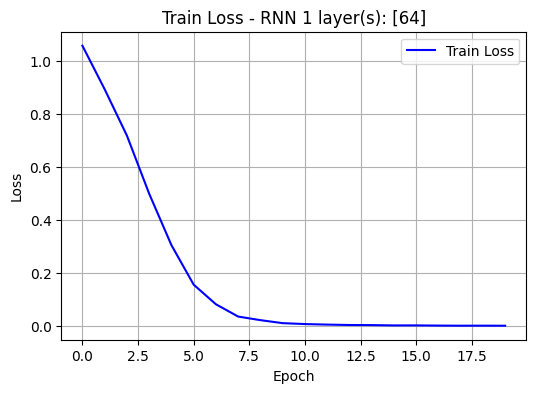

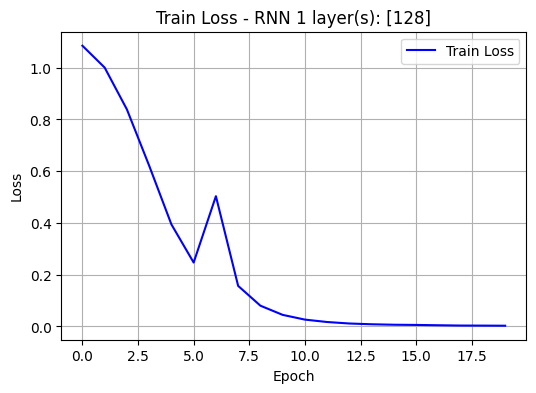

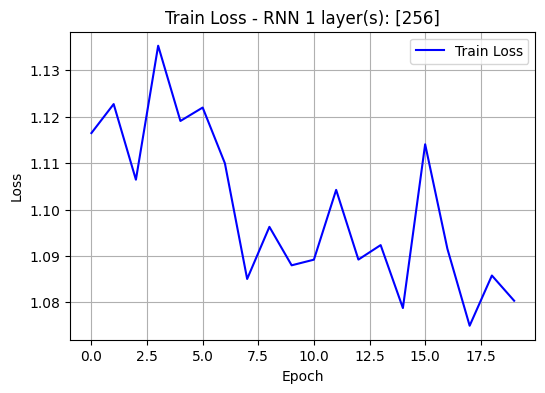

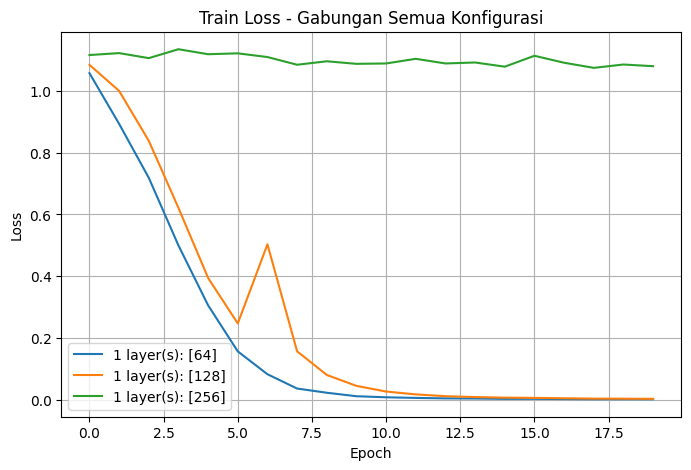

In [14]:
for result in results:
    config = result['config']
    loss = result['history']['loss']

    plt.figure(figsize=(6, 4))
    plt.plot(loss, color='blue', label='Train Loss')
    plt.title(f"Train Loss - RNN {len(config)} layer(s): {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    loss = result['history']['loss']
    label = f"{len(config)} layer(s): {config}"
    plt.plot(loss, label=label)

plt.title("Train Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

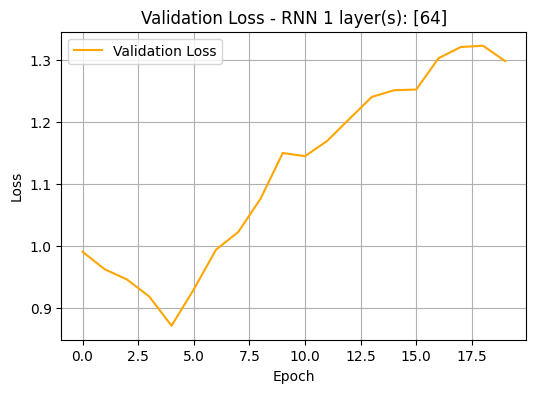

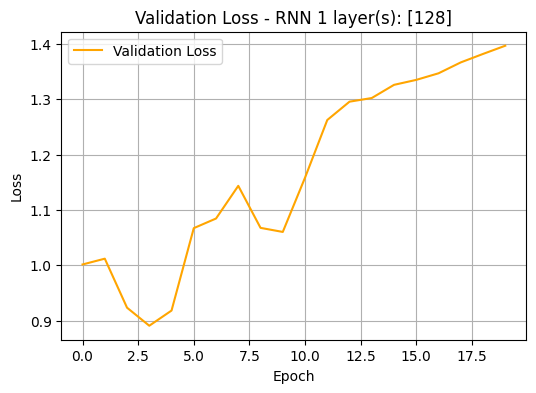

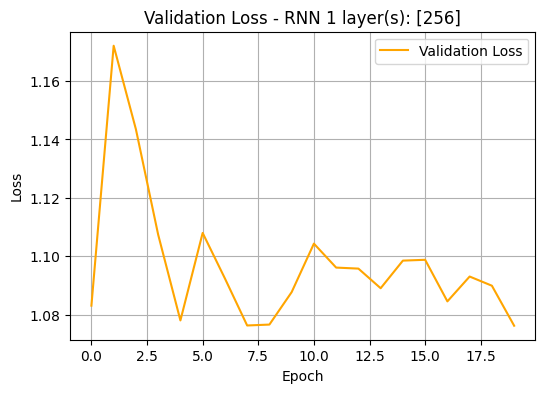

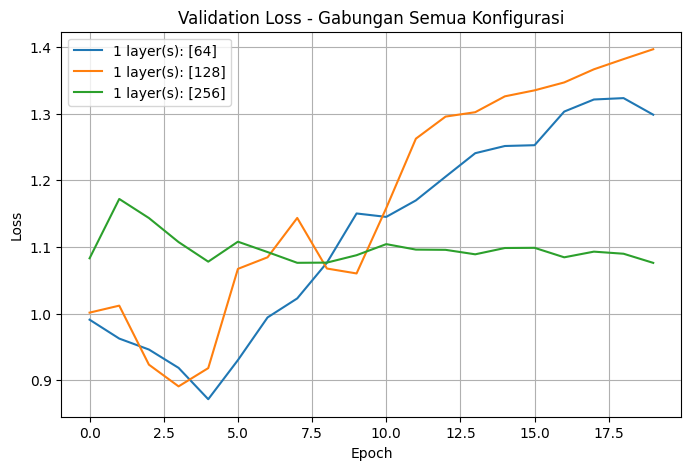

In [15]:
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']

    plt.figure(figsize=(6, 4))
    plt.plot(val_loss, color='orange', label='Validation Loss')
    plt.title(f"Validation Loss - RNN {len(config)} layer(s): {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']
    label = f"{len(config)} layer(s): {config}"
    plt.plot(val_loss, label=label)

plt.title("Validation Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


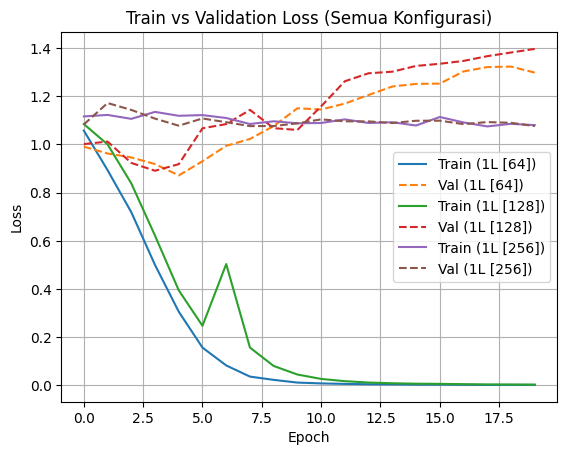

In [16]:
for result in results:
    config = result['config']
    history = result['history']
    label = f"{len(config)}L {config}"

    plt.plot(history['loss'], label=f"Train ({label})", linestyle='-')
    plt.plot(history['val_loss'], label=f"Val ({label})", linestyle='--')

plt.title("Train vs Validation Loss (Semua Konfigurasi)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
print("REKAP F1-SCORE PER KONFIGURASI:")
for result in results:
    print(f"RNN {result['config']} → F1 Keras: {result['f1_keras']:.4f} | F1 Manual: {result['f1_manual']:.4f}")



REKAP F1-SCORE PER KONFIGURASI:
RNN [64] → F1 Keras: 0.5726 | F1 Manual: 0.5726
RNN [128] → F1 Keras: 0.5726 | F1 Manual: 0.5726
RNN [256] → F1 Keras: 0.1827 | F1 Manual: 0.1827


# Uji coba banyak pengaruh bidirectional dan undirectional

In [18]:
rnn_variants = [
    True,
    False          
]

results = []

In [19]:
for config in rnn_variants:
    print(f"\nTraining RNN dengan konfigurasi bidirectional: {config}")

    model = SimpleRNNKeras(
        max_vocab=10000,
        max_len=100,
        rnn_units=[64],
        rnn_activations=['tanh'],
        dense_units=[32, 3],
        dense_activations=['relu', 'softmax'],
        bidirectional=config,
        dropout=0.3,
        learning_rate=1e-3
    )

    model.set_vectorized_data(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid,
        X_test=X_test,
        y_test=y_test
    )

    model.build_model()
    history = model.model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=20,
        batch_size=64,
        verbose=0,
        shuffle=False
    )

    y_pred_keras = np.argmax(model.model.predict(X_test), axis=1)
    f1_keras = f1_score(y_test, y_pred_keras, average='macro')

    path = f"model_rnn_layer{config}.npy"
    model.save_full_npz(path)

    results.append({
        'config': config,
        'f1_keras': f1_keras,
        'y_pred_keras': y_pred_keras,
        'npz_path': path,
        'history': history.history,
        'model': model
    })

    print(f"F1-score (Keras)  → {f1_keras:.8f}")



Training RNN dengan konfigurasi bidirectional: True
Adding RNN layer 1 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved full model to model_rnn_layerTrue.npy
F1-score (Keras)  → 0.62839334

Training RNN dengan konfigurasi bidirectional: False
Adding RNN layer 1 with 64 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Saved full model to model_rnn_layerFalse.npy
F1-score (Keras)  → 0.31230019


In [20]:
X_test_tensor = tc.tensor(X_test.numpy(), dtype=tc.long)
y_test_tensor = tc.tensor(y_test, dtype=tc.long)

for result in results:
    manual_model = SimpleRNNManual()
    manual_model.load_full_npz(result['npz_path'])

    y_pred_manual = manual_model.predict(X_test_tensor).cpu().numpy()
    f1_manual = f1_score(y_test, y_pred_manual, average='macro')

    result['y_pred_manual'] = y_pred_manual
    result['f1_manual'] = f1_manual

    print(f"F1-score (Manual) → {f1_manual:.8f}")

F1-score (Manual) → 0.62839334
F1-score (Manual) → 0.31230019


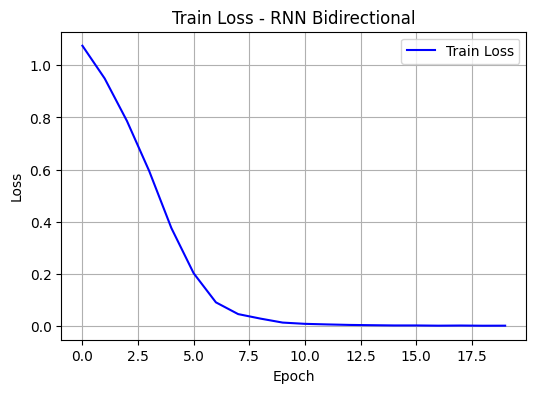

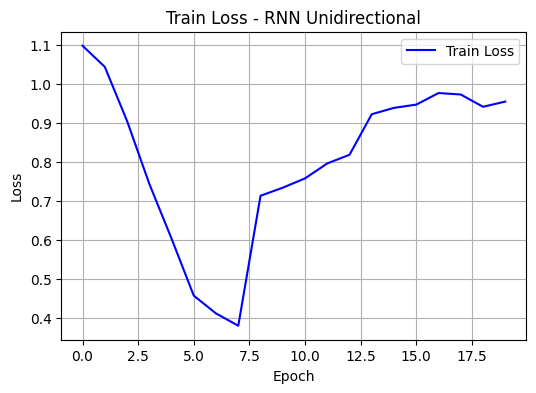

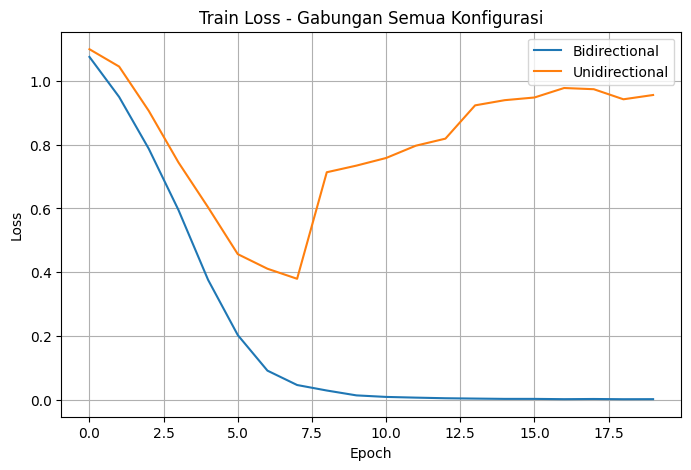

In [21]:
for result in results:
    config = result['config']
    loss = result['history']['loss']

    plt.figure(figsize=(6, 4))
    plt.plot(loss, color='blue', label='Train Loss')
    plt.title(f"Train Loss - RNN {'Bidirectional' if config else 'Unidirectional'}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    loss = result['history']['loss']
    label = f"{'Bidirectional' if config else 'Unidirectional'}"
    plt.plot(loss, label=label)

plt.title("Train Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


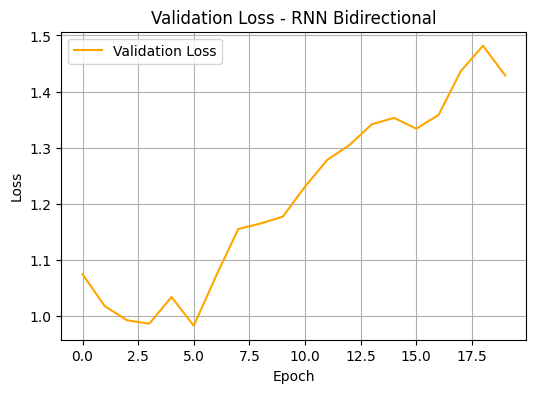

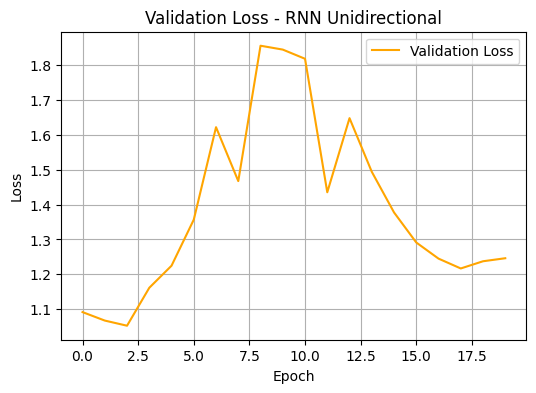

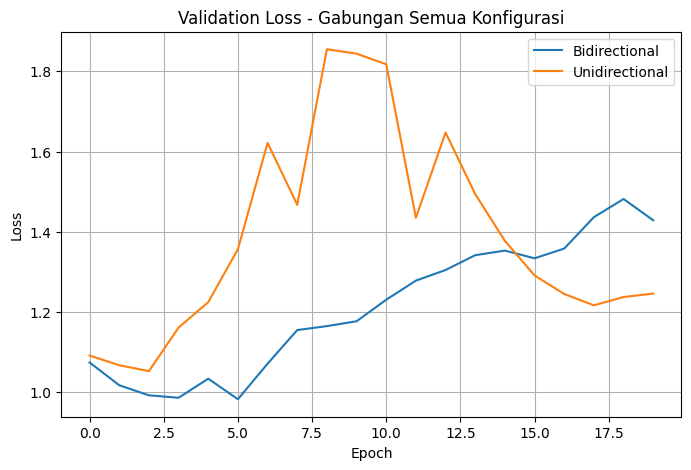

In [22]:
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']

    plt.figure(figsize=(6, 4))
    plt.plot(val_loss, color='orange', label='Validation Loss')
    plt.title(f"Validation Loss - RNN {'Bidirectional' if config else 'Unidirectional'}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']
    val_loss = result['history']['val_loss']
    label = f"{'Bidirectional' if config else 'Unidirectional'}"
    plt.plot(val_loss, label=label)

plt.title("Validation Loss - Gabungan Semua Konfigurasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


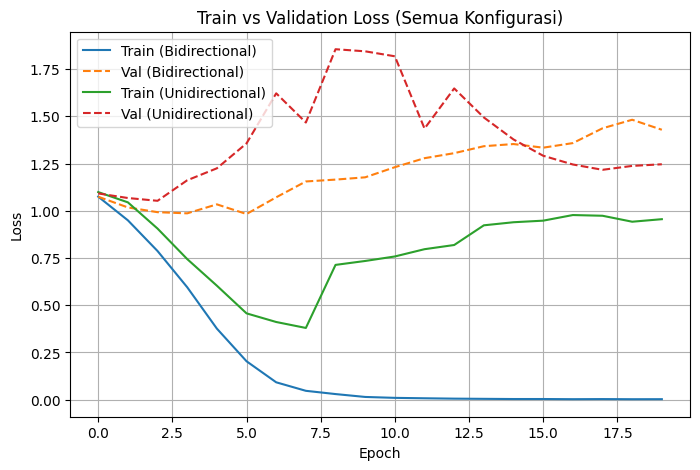

In [23]:
plt.figure(figsize=(8, 5))
for result in results:
    config = result['config']  # True / False
    history = result['history']
    label = "Bidirectional" if config else "Unidirectional"

    plt.plot(history['loss'], label=f"Train ({label})", linestyle='-')
    plt.plot(history['val_loss'], label=f"Val ({label})", linestyle='--')

plt.title("Train vs Validation Loss (Semua Konfigurasi)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


In [24]:
print("REKAP F1-SCORE PER KONFIGURASI:")
for result in results:
    config = result['config']  # hanya True / False
    rnn_type = "Bidirectional" if config else "Unidirectional"
    print(f"{rnn_type} → F1 Keras: {result['f1_keras']:.4f} | F1 Manual: {result['f1_manual']:.4f}")


REKAP F1-SCORE PER KONFIGURASI:
Bidirectional → F1 Keras: 0.6284 | F1 Manual: 0.6284
Unidirectional → F1 Keras: 0.3123 | F1 Manual: 0.3123
